# #imports

In [1]:
import pandas as pd
import numpy as np
import psycopg2

In [2]:
conn_params = {
    "host" : "srvdados",
    "database" : "postgres",
    "user":"compras",
    "password": "pecist@compr@s2024"
}

In [3]:
ve = """
    SELECT 
    pp.cod_pro,
    pp.cd_loja,
    pp.dt_emissao::date AS dt_emissao,
    SUM(pp.qtde_ven) AS vendas
FROM "D-1".prod_ped pp
JOIN "D-1".cliente c 
    ON pp.codcli = c.codcli
WHERE 
    pp.tipped = 'V'
    AND pp.dt_emissao >= DATE '2019-01-01'
    AND pp.cd_loja NOT IN ('01','08','09')
    and c.codcli not in ('13996','16100','18400','20000','23000','02608','24000','00270','20690','20691','20692','20693','23011','99999','88888','21097')
    and pp.codvde not in ('0100','0001','0006','2319')
    AND c.codarea <> '112'
    AND c.codcid <> '0501'
GROUP BY
    pp.cod_pro,
    pp.cd_loja,
    pp.dt_emissao::date;
"""

In [4]:
dv = """
   SELECT 
    pe.cd_produto AS cod_pro,
    pe.cd_loja,
    e.dt_emissao::date AS dt_emissao,
    SUM(pe.qt_devolve) AS devolucoes
FROM "D-1".prod_ent pe
JOIN "D-1".entrada e
    ON e.cd_loja = pe.cd_loja
    AND e.sg_serie = pe.sg_serie
    AND e.nu_nota = pe.nu_nota
JOIN "D-1".cliente cli
    ON cli.codcli = pe.cd_cliente
WHERE
    e.dt_emissao >= DATE '2019-01-01'
    AND e.in_cancela = 'N'
    AND e.in_clifor = 'C'
    AND UPPER(e.nfeenvstat) NOT LIKE '%DENEG%'
    AND pe.cd_cfop NOT IN ('1949', '2949', '1603')
    AND cli.codcli NOT IN ('99999','88888','21097')
    AND cli.codcid <> '0501'
    AND cli.codarea <> '112'
    AND pe.cd_loja NOT IN ('01','08','09')
GROUP BY
    pe.cd_produto,
    pe.cd_loja,
    e.dt_emissao::date;
"""

In [5]:
with psycopg2.connect(**conn_params) as conn:
    ven = pd.read_sql(ve, conn)

C:\Users\priscila.marques\AppData\Local\Temp\ipykernel_7812\2245771844.py:2: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  ven = pd.read_sql(ve, conn)


In [6]:
with psycopg2.connect(**conn_params) as conn:
    dev = pd.read_sql(dv, conn)

C:\Users\priscila.marques\AppData\Local\Temp\ipykernel_7812\2747580985.py:2: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  dev = pd.read_sql(dv, conn)


In [7]:
ven['dt_emissao'] = pd.to_datetime(ven['dt_emissao']).dt.normalize()
dev['dt_emissao'] = pd.to_datetime(dev['dt_emissao']).dt.normalize()

In [8]:
df = ven.merge(
    dev,
    on=["cod_pro", "cd_loja", "dt_emissao"],
    how="outer"
)

df["vendas"] = df["vendas"].fillna(0)
df["devolucoes"] = df["devolucoes"].fillna(0)

df["vendas_líquidas"] = df["vendas"] - df["devolucoes"]
df.loc[df["vendas_líquidas"] < 0, "vendas_líquidas"] = 0



In [9]:
df["ano_mes"] = df["dt_emissao"].dt.to_period("M")

# soma vendas líquidas por produto, loja e mês
vendas_mensais = (
    df
    .groupby(["cod_pro", "cd_loja", "ano_mes"])
    .agg(vendas_mes=("vendas_líquidas", "sum"))
    .reset_index()
)

# calcula a média mensal (para filtrar alto giro)
media_mensal = (
    vendas_mensais
    .groupby(["cod_pro", "cd_loja"])
    .agg(media_vendas_mes=("vendas_mes", "mean"))
    .reset_index()
)

# filtra produtos de alto giro (média mensal > 9 por exemplo)
prod_alto_giro_media = media_mensal[media_mensal["media_vendas_mes"] > 9][["cod_pro", "cd_loja"]]

df_lognormal = vendas_mensais.merge(prod_alto_giro_media, on=["cod_pro", "cd_loja"], how="inner")

In [10]:
dias_obs = (
    df
    .groupby(["cod_pro", "cd_loja"])
    .agg(
        dias_com_mov=("dt_emissao", "nunique"),
        data_min=("dt_emissao", "min"),
        data_max=("dt_emissao", "max")
    )
)

dias_obs["dias_total"] = (
    dias_obs["data_max"] - dias_obs["data_min"]
).dt.days + 1

dias_obs["dias_zero"] = (
    dias_obs["dias_total"] - dias_obs["dias_com_mov"]
)

In [11]:
base_modelo = df.merge(
    dias_obs.reset_index(),
    on=["cod_pro", "cd_loja"],
    how="left"
)

# #AIC

In [12]:
import numpy as np
import pandas as pd
from scipy import stats

In [13]:
#lognormal
def aic_lognormal(dados):
    # floc=0 força suporte positivo
    shape, loc, scale = stats.lognorm.fit(dados, floc=0)
    
    loglik = np.sum(stats.lognorm.logpdf(dados, shape, loc, scale))
    k = 2  # shape, scale
    return loglik, 2*k - 2*loglik

In [14]:
#gamma
def aic_gamma(dados):
    try:
        # tenta MLE padrão
        shape, loc, scale = stats.gamma.fit(dados, floc=0)
        
    except Exception:
        # fallback: método dos momentos
        mean = dados.mean()
        var = dados.var()
        
        if var <= 0:
            return np.nan, np.nan
        
        shape = mean**2 / var
        scale = var / mean
        loc = 0
    
    loglik = np.sum(stats.gamma.logpdf(dados, shape, loc, scale))
    k = 2  # shape, scale
    return loglik, 2*k - 2*loglik

In [15]:
#Binomial negativa
def aic_binomial_negativa(dados):
    mu = dados.mean()
    var = dados.var()
    
    # NB só faz sentido se houver overdispersion
    if var <= mu:
        return np.nan, np.nan
    
    p = mu / var
    r = mu * p / (1 - p)
    
    loglik = np.sum(stats.nbinom.logpmf(dados, r, p))
    k = 2  # r, p
    return loglik, 2*k - 2*loglik

In [16]:
resultados = []

for (cod_pro, cd_loja), g in df_lognormal.groupby(["cod_pro", "cd_loja"]):
    dados = g["vendas_mes"][g["vendas_mes"] > 0].values
    if len(dados) < 20:  # mínimo de 20 meses
        continue 
    
    ll_ln, aic_ln = aic_lognormal(dados)
    ll_g, aic_g = aic_gamma(dados)
    ll_nb, aic_nb = aic_binomial_negativa(dados)
    
    resultados.extend([
        {
            "cod_pro": cod_pro,
            "cd_loja": cd_loja,
            "distribuicao": "lognormal",
            "loglik": ll_ln,
            "aic": aic_ln
        },
        {
            "cod_pro": cod_pro,
            "cd_loja": cd_loja,
            "distribuicao": "gamma",
            "loglik": ll_g,
            "aic": aic_g
        },
        {
            "cod_pro": cod_pro,
            "cd_loja": cd_loja,
            "distribuicao": "binomial_negativa",
            "loglik": ll_nb,
            "aic": aic_nb
        }
    ])

In [17]:
resultado_final = pd.DataFrame(resultados)

resultado_final["delta_aic"] = (
    resultado_final
    .groupby(["cod_pro", "cd_loja"])["aic"]
    .transform(lambda x: x - x.min())
)


In [18]:
melhor_modelo = ( 
    resultado_final 
    .sort_values("delta_aic") 
    .groupby(["cod_pro", "cd_loja"]) 
    .head(1) 
    ) 

print(melhor_modelo.head(20))

      cod_pro cd_loja       distribuicao      loglik         aic  delta_aic
0      000069      05          lognormal -132.423587  268.847174        0.0
11207  041277      05  binomial_negativa -161.092145  326.184290        0.0
4646   021151      03  binomial_negativa -231.956356  467.912712        0.0
11210  041277      06  binomial_negativa -137.562617  279.125234        0.0
11213  041277      07  binomial_negativa  -61.475261  126.950522        0.0
4642   021147      07              gamma  -63.158377  130.316754        0.0
4640   021147      06  binomial_negativa -149.021333  302.042666        0.0
11215  041304      05              gamma -133.769543  271.539086        0.0
4636   021147      05              gamma -181.667073  367.334147        0.0
11218  041775      04              gamma -177.898443  359.796886        0.0
4634   021147      04  binomial_negativa -243.302206  490.604412        0.0
11221  041790      04              gamma -198.739457  401.478915        0.0
11225  04179

In [19]:
melhor_modelo["distribuicao"].value_counts()

distribuicao
gamma                3081
binomial_negativa    1780
lognormal            1144
Name: count, dtype: int64

# lognormais

In [20]:
#pegando só os lognormais 
prod_lognormal = melhor_modelo[
    melhor_modelo["distribuicao"] == "lognormal"
]

In [21]:
df_lognormal = df_lognormal.merge(
    prod_lognormal[["cod_pro", "cd_loja"]],
    on=["cod_pro", "cd_loja"],
    how="inner"
)

In [22]:
params_lognormal = (
    df_lognormal
    .groupby(["cod_pro", "cd_loja"])
    .apply(
        lambda x: stats.lognorm.fit(
            x["vendas_mes"][x["vendas_mes"] > 0],  # sem zeros
            floc=0
        )
    )
    .reset_index(name="params")
)

C:\Users\priscila.marques\AppData\Local\Temp\ipykernel_7812\3190159952.py:4: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(


In [23]:
produto_ex = params_lognormal.sample(1).iloc[0]

cod_pro = produto_ex["cod_pro"]
cd_loja = produto_ex["cd_loja"]

shape, loc, scale = produto_ex["params"]

print(cod_pro, cd_loja)
print("shape:", shape, "scale:", scale)

081425 04
shape: 1.1543386441055759 scale: 35.89963190829449


In [24]:
nivel_servico = 0.95

estoque_95 = stats.lognorm.ppf(
    nivel_servico,
    s=shape,
    loc=loc,
    scale=scale
)

estoque_95

239.7136647846813

In [25]:
prob_perda = 1 - stats.lognorm.cdf(
    estoque_95,
    s=shape,
    loc=loc,
    scale=scale
)

prob_perda

0.050000000000000044

In [26]:
df_lognormal

,cod_pro,cd_loja,ano_mes,vendas_mes
0,000069,05,2022-01,4.0
1,000069,05,2022-02,17.0
2,000069,05,2022-03,4.0
3,000069,05,2022-04,4.0
4,000069,05,2022-05,4.0
...,...,...,...,...
39807,085936,06,2025-08,38.0
39808,085936,06,2025-09,28.0
39809,085936,06,2025-10,23.0
39810,085936,06,2025-11,6.0


In [27]:
nivel_servico = 0.95

# lista para armazenar resultados
estoques = []

# loop pelos produtos/lojas de alto giro
for (cod_pro, cd_loja), g in df_lognormal.groupby(["cod_pro", "cd_loja"]):
    
    # pega só os meses com vendas positivas
    vendas_pos = g["vendas_mes"][g["vendas_mes"] > 0].values
    
    if len(vendas_pos) < 20:  # mínimo de 20 meses
        continue
    
    # ajuste lognormal
    try:
        shape, loc, scale = stats.lognorm.fit(vendas_pos, floc=0)
    except:
        continue  # caso o fit falhe
    
    # estoque 95%
    estoque_95 = stats.lognorm.ppf(nivel_servico, s=shape, loc=loc, scale=scale)
    estoque_95 = int(np.round(estoque_95))
    
    # probabilidade de perda
    prob_perda = 1 - stats.lognorm.cdf(estoque_95, s=shape, loc=loc, scale=scale)
    
    estoques.append({
        "cod_pro": cod_pro,
        "cd_loja": cd_loja,
        "estoque_95": estoque_95,
        "prob_perda": prob_perda
    })

# cria dataframe final
df_estoques = pd.DataFrame(estoques)

# mostra os primeiros resultados
print(df_estoques.head())

  cod_pro cd_loja  estoque_95  prob_perda
0  000069      05          25    0.052226
1  000263      06          29    0.050827
2  000276      04          59    0.049181
3  000276      05          65    0.049226
4  000276      06          62    0.048703


In [54]:
df_lognormal

,cod_pro,cd_loja,ano_mes,vendas_mes
0,000069,05,2022-01,4.0
1,000069,05,2022-02,17.0
2,000069,05,2022-03,4.0
3,000069,05,2022-04,4.0
4,000069,05,2022-05,4.0
...,...,...,...,...
39807,085936,06,2025-08,38.0
39808,085936,06,2025-09,28.0
39809,085936,06,2025-10,23.0
39810,085936,06,2025-11,6.0


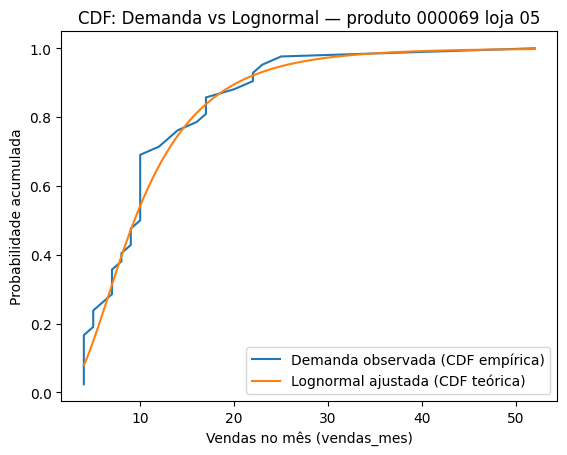

In [84]:

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import lognorm

produto = '000069'  #'021143'
loja = '05'   #'04'

dfp = df_lognormal[
    (df_lognormal['cod_pro'] == produto) &
    (df_lognormal['cd_loja'] == loja)
]

demanda = dfp['vendas_mes'].astype(float)

# lognormal só aceita > 0
demanda_pos = demanda[demanda > 0]

if len(demanda_pos) < 5:
    print("Poucos meses com vendas_mes > 0 para ajustar lognormal.")
else:
    # Ajuste lognormal (fixa loc=0, típico pra demanda >0)
    s, loc, scale = lognorm.fit(demanda_pos, floc=0)

    # CDF empírica
    x_emp = np.sort(demanda_pos.values)
    y_emp = np.arange(1, len(x_emp) + 1) / len(x_emp)

    # CDF teórica
    x = np.linspace(x_emp.min(), x_emp.max(), 400)
    y_theo = lognorm.cdf(x, s=s, loc=loc, scale=scale)

    plt.figure()
    plt.plot(x_emp, y_emp, label='Demanda observada (CDF empírica)')
    plt.plot(x, y_theo, label='Lognormal ajustada (CDF teórica)')
    plt.xlabel('Vendas no mês (vendas_mes)')
    plt.ylabel('Probabilidade acumulada')
    plt.title(f'CDF: Demanda vs Lognormal — produto {produto} loja {loja}')
    plt.legend()
    plt.show()

# #simula lognormais


In [38]:
rel_venda = '''
select
        pp.cd_loja,
        pp.cod_pro,
        pp.qtde_ven as qtde,
        pp.dt_emissao,
        pp.preco,
        pp.vl_mc
from
        "D-1".prod_ped pp
left join
        "D-1".cliente c on pp.codcli = c.codcli
where 
        pp.tipped = 'V'
        and pp.dt_emissao >= current_date - 90
        and c.codcli not in ('13996','16100','18400','20000','02608','00270','20690','20691','20692','20693','21097')
        and pp.codvde not in ('0100','0001','0006','2319')
        and c.codarea <> '112'
        and c.codcid <> '0501' 
        AND pp.cd_loja != '08'  
'''

In [39]:
rel_devolucao = '''
    SELECT
            pe.cd_produto AS cod_pro,
            pe.cd_loja,
            SUM(pe.qt_devolve) AS qtde,
            pe.dt_emissao
        FROM "D-1".prod_ent pe
        JOIN "D-1".entrada e
            ON e.cd_loja = pe.cd_loja
            AND e.sg_serie = pe.sg_serie
            AND e.nu_nota = pe.nu_nota
        JOIN "D-1".cliente cli
            ON cli.codcli = pe.cd_cliente
        WHERE
            e.dt_emissao >= current_date - 90
            AND e.in_cancela = 'N'
            AND e.in_clifor = 'C'
            AND UPPER(e.nfeenvstat) NOT LIKE '%%DENEG%%'
            AND pe.cd_cfop NOT IN ('1949', '2949', '1603')
            AND cli.codcli NOT IN ('21097')
            AND cli.codcid <> '0501'
            AND cli.codarea <> '112'
            AND pe.cd_loja != '08'  
        GROUP BY pe.cd_produto, pe.cd_loja, pe.dt_emissao    
        '''

In [40]:
with psycopg2.connect(**conn_params) as conn:
    rel_venda = pd.read_sql(rel_venda, conn)

C:\Users\priscila.marques\AppData\Local\Temp\ipykernel_7812\1083772120.py:2: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  rel_venda = pd.read_sql(rel_venda, conn)


In [41]:
with psycopg2.connect(**conn_params) as conn:
    rel_devolucao = pd.read_sql(rel_devolucao, conn)

C:\Users\priscila.marques\AppData\Local\Temp\ipykernel_7812\382021153.py:2: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  rel_devolucao = pd.read_sql(rel_devolucao, conn)


In [62]:
prod = '000069'   # exemplo: '000069'
loja = '05'   # exemplo: '05'

if prod and loja:
    # simulação só para o produto/loja selecionado
    vendas = rel_venda[(rel_venda['cod_pro'] == prod) & (rel_venda['cd_loja'] == loja)].copy()
    devol  = rel_devolucao[(rel_devolucao['cod_pro'] == prod) & (rel_devolucao['cd_loja'] == loja)].copy()
    # estoque inicial só desse produto/loja
    estoque_valor = df_estoques.set_index(['cod_pro','cd_loja']).get((prod, loja), 0)
    reg_prod = {(prod, loja): estoque_valor}
else:
    # simulação para todos os produtos/lojas
    vendas = rel_venda.copy()
    devol  = rel_devolucao.copy()
    # cria dicionário com estoque inicial de cada produto/loja
    reg_prod = df_estoques.set_index(['cod_pro','cd_loja'])['estoque_95'].to_dict()

In [63]:
vendas['dt_emissao'] = pd.to_datetime(vendas['dt_emissao'])
devol['dt_emissao'] = pd.to_datetime(devol['dt_emissao'])

# vendas negativas (reduzem estoque), devoluções positivas
vendas['qtde'] = -vendas['qtde']
devol['qtde'] = devol['qtde']


In [64]:
# junta em ordem cronológica
sim_dados = pd.concat([
    vendas[['cod_pro','cd_loja','dt_emissao','qtde']].assign(tipo='venda'),
    devol[['cod_pro','cd_loja','dt_emissao','qtde']].assign(tipo='devolucao')
], ignore_index=True).sort_values('dt_emissao').reset_index(drop=True)

data_venda_venda = sim_dados[sim_dados['tipo'] == 'venda'].copy()

In [ ]:
from datetime import timedelta
def cria_reabastecimento(row, reg_prod_estoque):
    row_r = row.copy()
    row_r['dt_emissao'] += timedelta(days=30)  # 30 dias depois
    row_r['tipo'] = 'reabastecimento'
    
    chave = (row['cod_pro'], row['cd_loja'])
    estoque_max = reg_prod.get(chave, 0)  # estoque_95
    
    # quantidade que realmente saiu do estoque (quantidade atendida)
    # se row['venda_perdida'] ainda não existe, considera 0
    venda_perdida = row.get('venda_perdida', 0)
    qtd_vendida = -row['qtde'] - venda_perdida
    qtd_vendida = max(0, qtd_vendida)
    
    # limita pelo estoque_95
    estoque_atual = reg_prod_estoque.get(chave, 0)
    row_r['qtde'] = min(qtd_vendida, max(0, estoque_max - estoque_atual))
    
    # Marca de origem: número da venda + 'R'
    row_r['origem'] = f"{row.name}R"
    
    return row_r

# --- Inicializa o estoque antes de gerar reabastecimentos ---
reg_prod_estoque = reg_prod.copy()
sim_dados['estoque'] = None
sim_dados['venda_perdida'] = 0

# Preenche estoque e vendas perdidas iniciais
for i, row in sim_dados.iterrows():
    chave = (row['cod_pro'], row['cd_loja'])
    estoque_atual = reg_prod_estoque.get(chave, 0)
    if row['tipo'] == 'venda':
        estoque_atual += row['qtde']
        if estoque_atual < 0:
            sim_dados.at[i,'venda_perdida'] = -estoque_atual
            estoque_atual = 0
    elif row['tipo'] == 'devolucao':
        estoque_atual += row['qtde']
    sim_dados.at[i,'estoque'] = estoque_atual
    reg_prod_estoque[chave] = estoque_atual

# --- Gera reabastecimentos usando estoque atualizado ---
data_venda_venda = sim_dados[sim_dados['tipo']=='venda'].copy()
data_compra = data_venda_venda.apply(lambda row: cria_reabastecimento(row, reg_prod_estoque), axis=1)

# --- Junta tudo e ordena ---
sim_loja = pd.concat([sim_dados, data_compra], ignore_index=True)
sim_loja = sim_loja.sort_values(['dt_emissao','cod_pro','cd_loja']).reset_index(drop=True)

# --- Simula estoque diário incluindo reabastecimentos ---
reg_prod_estoque = reg_prod.copy()
sim_loja['estoque'] = None
sim_loja['venda_perdida'] = 0

for i, row in sim_loja.iterrows():
    chave = (row['cod_pro'], row['cd_loja'])
    estoque_atual = reg_prod_estoque.get(chave, 0)
    estoque_max = reg_prod.get(chave, 0)
    
    if row['tipo'] == 'reabastecimento':
        incremento = min(row['qtde'], estoque_max - estoque_atual)
        estoque_atual += incremento
        sim_loja.at[i,'qtde'] = incremento  # ajusta qtde se limite atingido
    elif row['tipo'] == 'venda':
        estoque_atual += row['qtde']
        if estoque_atual < 0:
            sim_loja.at[i,'venda_perdida'] = -estoque_atual
            estoque_atual = 0
    else:  # devolução
        estoque_atual += row['qtde']
    
    sim_loja.at[i,'estoque'] = estoque_atual
    reg_prod_estoque[chave] = estoque_atual

# --- Resultados finais ---
venda_total = -sim_loja[sim_loja['tipo']=='venda']['qtde'].sum()
venda_perdida = sim_loja['venda_perdida'].sum()
percentual_perda = venda_perdida / venda_total * 100

print(f"Vendas totais previstas: {venda_total:.0f}")
print(f"Vendas perdidas: {venda_perdida:.0f}")
print(f"Percentual de perda: {percentual_perda:.2f}%")

#estoque_maximo = reg_prod.get((prod, loja), 0)
#print(f"Estoque máximo (estoque_95) para este produto/loja: {estoque_maximo}")


Vendas totais previstas: 16
Vendas perdidas: 16
Percentual de perda: 100.00%
Estoque máximo (estoque_95) para este produto/loja: 0


In [68]:
sim_loja[['cod_pro','cd_loja','dt_emissao','qtde','estoque','venda_perdida','tipo','origem']]

,cod_pro,cd_loja,dt_emissao,qtde,estoque,venda_perdida,tipo,origem
0,000069,05,2025-11-05,-8.0,0,8,venda,NaN
1,000069,05,2025-11-10,-4.0,0,4,venda,NaN
2,000069,05,2025-12-05,0.0,0.0,0,reabastecimento,0R
3,000069,05,2025-12-10,0.0,0.0,0,reabastecimento,1R
4,000069,05,2025-12-16,-1.0,0,1,venda,NaN
5,000069,05,2025-12-26,-2.0,0,2,venda,NaN
6,000069,05,2025-12-27,-1.0,0,1,venda,NaN
7,000069,05,2026-01-15,0.0,0.0,0,reabastecimento,2R
8,000069,05,2026-01-25,0.0,0.0,0,reabastecimento,3R
9,000069,05,2026-01-26,0.0,0.0,0,reabastecimento,4R


In [ ]:
vendas_perdidas = sim_loja[sim_loja['venda_perdida'] > 0]

if vendas_perdidas.empty:
    print("Nenhuma venda perdida foi registrada.")
else:
    print(f"Existem {len(vendas_perdidas)} registros de vendas perdidas.")
    print(vendas_perdidas[['cod_pro','cd_loja','dt_emissao','venda_perdida']].head(20))

Existem 6899 registros de vendas perdidas.
      cod_pro cd_loja dt_emissao  venda_perdida
21341  025260      05 2025-10-08             15
40676  077440      07 2025-10-10              1
42334  077440      07 2025-10-10             10
47065  036540      03 2025-10-13              1
48395  036540      03 2025-10-13              1
49284  036540      03 2025-10-13              1
50569  036540      03 2025-10-13              1
50711  036540      03 2025-10-13              1
52270  036540      03 2025-10-13              1
52447  036540      03 2025-10-13              1
54736  017185      03 2025-10-13              1
54756  017185      03 2025-10-13              1
55034  025260      05 2025-10-13              1
55328  036540      03 2025-10-13              1
55445  036540      03 2025-10-13              1
55533  017185      03 2025-10-13              1
55719  058369      04 2025-10-13              4
56356  017185      03 2025-10-13              1
56382  017185      03 2025-10-13             